# Machine Learning Engineer Nanodegree - Capstone Project

## Santander Customer Transaction Prediction

This project's objective is to predict whether a customer will make a specific transaction in the future or not, regardless of the amount of money transacted. To achieve this objective we'll be using anonymized data consisting of 200 features, 200k observations for training and another 200k for testing.

### Loading data

In [1]:
# Importing main libraries for the project
# Other eventual libraries will be imported on demand
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display # to use display() for DataFrames


# Loading training and testing data
training_data = pd.read_csv("train.csv")
testing_data = pd.read_csv("test.csv")

# Separating features and targets
training_features = training_data.drop(['ID_code', 'target'], axis=1)
training_targets = training_data[['target']]

testing_features = testing_data.drop(['ID_code'], axis=1)

# Loading sample submission data
submission = pd.read_csv('sample_submission.csv')

# Peeking at first 10 observations
display(training_data.head(n=10))

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
5,train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,...,-6.3068,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602
6,train_6,0,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,...,8.7830,6.4521,3.5325,0.1777,18.3314,0.5845,9.1104,9.1143,10.8869,-3.2097
7,train_7,0,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,...,13.1700,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806
8,train_8,0,16.1071,2.4426,13.9307,5.6327,8.8014,6.1630,4.4514,10.1854,...,1.4298,14.7510,1.6395,1.4181,14.8370,-1.9940,-1.0733,8.1975,19.5114,4.8453
9,train_9,0,12.5088,1.9743,8.8960,5.4508,13.6043,-16.2859,6.0637,16.8410,...,0.5543,6.3160,1.0371,3.6885,14.8344,0.4467,14.1287,7.9133,16.2375,14.2514


### Data Exploration and Visualization

Total number of customers: 200000
Customers that will not make future transactions: 179902
Customers that will make future transactions: 20098
Percentage of customers tha will make future transactions: 10.049%


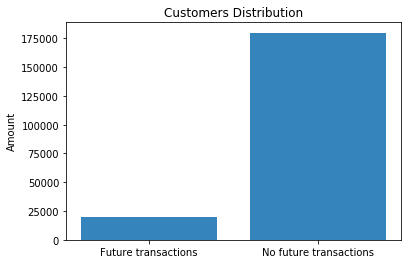

In [2]:
# Checking if data is balanced

# Number of customers
n_cust = training_data.shape[0]

# Number of customers that will not make future transactions
n_no_fut_trans = training_data[training_data["target"] == 0].shape[0]

# Number of customers that will make future transactions
n_fut_trans = training_data[training_data["target"] == 1].shape[0]

positions = [0.5, 1.5]
customers = [n_fut_trans, n_no_fut_trans]
labels = ['Future transactions', 'No future transactions' ]

plt.bar(positions, customers, align='center', alpha=0.9)
plt.xticks(positions, labels)
plt.ylabel('Amount')
plt.title('Customers Distribution')

print("Total number of customers: {}".format(n_cust))
print("Customers that will not make future transactions: {}".format(n_no_fut_trans))
print("Customers that will make future transactions: {}".format(n_fut_trans))
print("Percentage of customers tha will make future transactions: {}%".format(n_fut_trans/n_cust*100))

C:\Users\bonav\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\bonav\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


Number of normally distributted variables: 0
Number of not normally distributted variables: 200


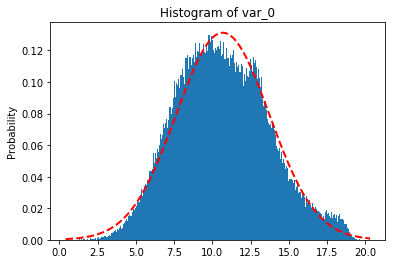

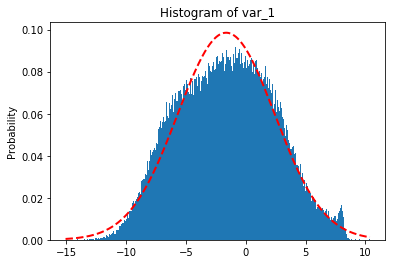

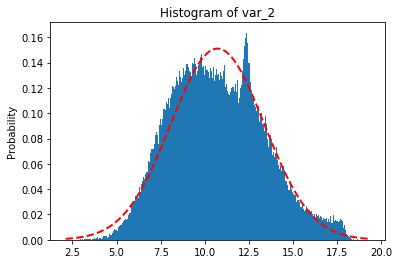

In [3]:
# Check training features distributions
from collections import defaultdict
import matplotlib.mlab as mlab
from scipy.stats import norm, normaltest

figs = defaultdict()
hists = defaultdict()
best_fits = defaultdict()

normal_features = []
not_normal_features = []

i = 0
# significance level of 5%
alpha = 0.05
for col in training_features.columns: 
    figs[col] = plt.figure()
    
    hists[col] = figs[col].add_subplot(1,1,1)
    n, bins, patches = hists[col].hist(training_features[col], bins=500, normed=1)
    hists[col].set_ylabel('Probability')
    hists[col].set_title('Histogram of {}'.format(col))
    
    (mu, sigma) = norm.fit(training_features[col])
    
    best_fits[col] = mlab.normpdf(bins, mu, sigma) 
    plt.plot(bins, best_fits[col], 'r--', linewidth=2)
        
    i += 1
    if i == 3:
        break

for col in training_features.columns: 

    stat, p = normaltest(training_features[col])

    if p > alpha:
        normal_features.append(col)
    else:
        not_normal_features.append(col)

print('Number of normally distributted variables: {}'.format(len(normal_features)))
print('Number of not normally distributted variables: {}'.format(len(not_normal_features)))

In [4]:
# Checking features correlation
correlations_matrix = training_features.corr()

strong_corr = []
medium_corr = []
weak_corr = []
no_corr = []

features = training_features.columns

for i, row in enumerate(features):
    for j, col in enumerate(features):
        
        if i <= j:
            continue
            
        current_features = (features[i], features[j])
        
        if(abs(correlations_matrix.loc[row,col]) > 0.7):
            strong_corr.append(current_features)
        elif(abs(correlations_matrix.loc[row,col]) > 0.4):
            medium_corr.append(current_features)
        elif(abs(correlations_matrix.loc[row,col]) > 0.2):    
            weak_corr.append(current_features)
        else:
            no_corr.append(current_features)
    
print('Number of strong correlations: {}'.format(len(strong_corr)))
print('Number of medium correlations: {}'.format(len(medium_corr)))
print('Number of weak correlations: {}'.format(len(weak_corr)))
print('Number of no correlations: {}'.format(len(no_corr)))

Number of strong correlations: 0
Number of medium correlations: 0
Number of weak correlations: 0
Number of no correlations: 19900


C:\Users\bonav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\bonav\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


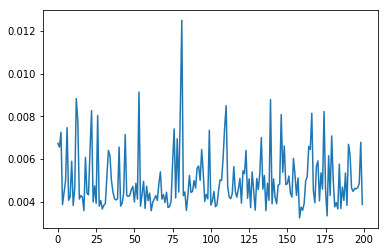

In [5]:
# Checking feature importances
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(training_features, training_targets)

plt.plot(rf.feature_importances_)
# Next line plots features names on x axis, but too many features make them kinda cramped (maybe resizing plot would help)
# plt.xticks(np.arange(training_features.shape[1]), training_features.columns.tolist(), rotation=90)

In [6]:
# Outlier detection (Turkey's method)
outliers_t  = []
repeated = []

# For each feature 
for feature in training_features.columns:
    
    # Calculate first quartile
    Q1 = np.percentile(training_features[feature], 25)
    
    # Calculate
    Q3 = np.percentile(training_features[feature], 75)
    
    # Calculate interquatile range * 1.5
    step = (Q3-Q1)*1.5
    
    for i in list((training_features[~((training_features[feature] >= Q1 - step) & (training_features[feature] <= Q3 + step))]).index.values):
        if i not in outliers_t:
            outliers_t.append(i)
        elif i not in repeated:
            repeated.append(i)


# Printing outliers amount and percentages
print("Number of points considered outliers in multiple features: {}".format(len(repeated)))
print("Number of points considered outliers in any feature: {}".format(len(outliers_t)))

print("Percentage of outliers in multiple features: {0:0.3f}%".format(len(repeated)/n_cust*100))
print("Percentage of outliers in any feature: {0:0.3f}%".format(len(outliers_t)/n_cust*100))

Number of points considered outliers in multiple features: 1556
Number of points considered outliers in any feature: 24896
Percentage of outliers in multiple features: 0.778%
Percentage of outliers in any feature: 12.448%


In [7]:
# Outlier detection (Local Outlier Factor)
# Not viable due to O(n²) complexity, takes too long as a result of dataset size
# Kept for future reference only

# from sklearn.neighbors import LocalOutlierFactor

# lof = LocalOutlierFactor()

# outliers_l = lof.fit_predict(X)

# print("Number of points considered outliers: {}".format(len(outliers_l[outliers_l == -1])))

In [10]:
# Checking for any missing values on training and testing data

tr_nans = training_data.isnull().any().any()
te_nans = testing_data.isnull().any().any()

print('Missing any data on training set: {}'.format(tr_nans))
print('Missing any data on testing set: {}'.format(te_nans))

Missing any data on training set: False
Missing any data on testing set: False


### Data pre-processing 

In [18]:
from sklearn.preprocessing import normalize, scale # normalize -> [0,1] | scale -> N(mu, sigma)

# Removing some outliers from original data 
filtered_training_features = training_features.drop(repeated)
filtered_training_targets = training_targets.drop(repeated)

filtered_testing_features = testing_features.drop(repeated)

# Rescaling training data
normal_training_features = normalize(training_features)
scale_training_features = scale(training_features)

# Rescaling testing data
normal_testing_features = normalize(testing_features)
scale_testing_features = scale(testing_features)

### Data balancing and Cross-validation

In [20]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

# Used for oversampling
smt = SMOTE(random_state=42)

# Used for undersampling
tomek = TomekLinks(random_state=42)

# Combine oversampling and undersampling
smt_tomek =SMOTETomek(random_state=42) 

# Used for cross-validation
n_folds = 10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

In [21]:
# To be used if number of features becomes an impeding factor due to time spent on models training/predicting 
# from sklearn.decomposition import PCA

# # Applying pca to the filtered data
# pca = PCA(n_components=0.9, svd_solver='full').fit(filtered_training_features.reset_index(drop=True))

# # Checking number of components
# print("Number of components after pca: {}".format(pca.n_components_))

# # Transforming data based on components
# transf_features = pca.transform(filtered_training_features)

### Pipeline functions

In [22]:
from sklearn.metrics import roc_auc_score, fbeta_score
from time import time

# Function used for the classifiers pipeline
def train_predict(classifier, X_train, y_train, X_test, y_test, sample_size=-1):
   
    results = {}
    
    if(sample_size == -1):
        sample_size = X_train.shape[0]
        
    start = time() # Get training start time
    classifier = classifier.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get training end time
    
    # Storing training time
    results['train_time'] = end-start
    
    start = time() # Get predictions start time
    predictions_test = classifier.predict(X_test)
    predictions_train = classifier.predict(X_train)
    end = time() # Get predictions end time
    
    results['pred_time'] = end-start
    
    # Compute area under the receive operating characterist curve using roc_auc_acore
    results['roc_train'] = roc_auc_score(y_train, predictions_train)
    results['roc_test'] = roc_auc_score(y_test, predictions_test)
    
    # Compute F-score using fbeta_score
    results['f_train'] = fbeta_score(y_train, predictions_train, beta=2)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=2)
    
    return results


In [29]:
# Code adapted from an udacity machine learning engineer nanodegree project 
def evaluate(results, roc_auc, f1):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 4, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'roc_train', 'f_train', 'pred_time', 'roc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("ROC AUC Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("ROC AUC Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("ROC AUC on Training set")
    ax[0, 2].set_title("F-score on Training set")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("ROC AUC Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for predictors
    ax[0, 1].axhline(y = roc_auc, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = roc_auc, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Set additional plots invisibles
    ax[0, 3].set_visible(False)
    ax[1, 3].axis('off')

    # Create legend
    for i, learner in enumerate(results.keys()):
        plt.bar(0, 0, color=colors[i], label=learner)
    plt.legend()
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

In [40]:
from collections import defaultdict

# Calculate the mean of kfold partitions metrics
def mean_result(results):
    
    final_results = defaultdict(dict)
    
    for clf, data in results.items():
        classifier_data = data
        
        for size, values in classifier_data.items():
            results = values
            
            train_time = 0.0
            pred_time = 0.0
            roc_train = 0.0
            roc_test = 0.0
            f_train = 0.0
            f_test = 0.0
            
            
            for fold_result in results:
                train_time += fold_result['train_time']
                pred_time += fold_result['pred_time']
                roc_train += fold_result['roc_train']
                roc_test += fold_result['roc_test']
                f_train += fold_result['f_train']
                f_test += fold_result['f_test']
            
            train_time /= len(results)
            pred_time /= len(results)
            roc_train /= len(results)
            roc_test /= len(results)
            f_train /= len(results)
            f_test /= len(results)
            
            result = {'train_time': train_time, 'pred_time': pred_time, \
                      'roc_train': roc_train, 'roc_test': roc_test, \
                      'f_train': f_train, 'f_test': f_test}
            
            final_results[clf][size] = result

    return final_results

### Supervised Learning Pipeline

In [45]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

clf_A = LogisticRegression(random_state=42)
clf_B = XGBClassifier()
clf_C = RandomForestClassifier(random_state=42)

results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = defaultdict(lambda: [])
    j = 0
    for train_index, test_index in skf.split(training_features, training_targets):

        # Separating training and testing data
        X_train, X_test = training_features.iloc[train_index], training_features.iloc[test_index]
        y_train, y_test = training_targets.iloc[train_index], training_targets.iloc[test_index]

        size_1 = int(0.01 * X_train.shape[0])
        size_10 =int(0.1 * X_train.shape[0])
        size_100 = X_train.shape[0]

        for i, samples in enumerate([size_1, size_10, size_100]):
            results[clf_name][i].append(train_predict(clf, X_train, y_train, X_test, y_test, samples))
        j += 1


C:\Users\bonav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bonav\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\bonav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bonav\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\bonav\Anaconda3\lib\site-packages\sklearn\linear_

C:\Users\bonav\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\bonav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bonav\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\bonav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bonav\Anaconda3\lib\site-packages\sklearn\utils\v

C:\Users\bonav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\bonav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\bonav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\bonav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

C:\Users\bonav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\bonav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\bonav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\bonav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

C:\Users\bonav\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
C:\Users\bonav\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
C:\Users\bonav\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
C:\Users\bonav\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
C:\Users\bonav\Anaconda3\lib\sit

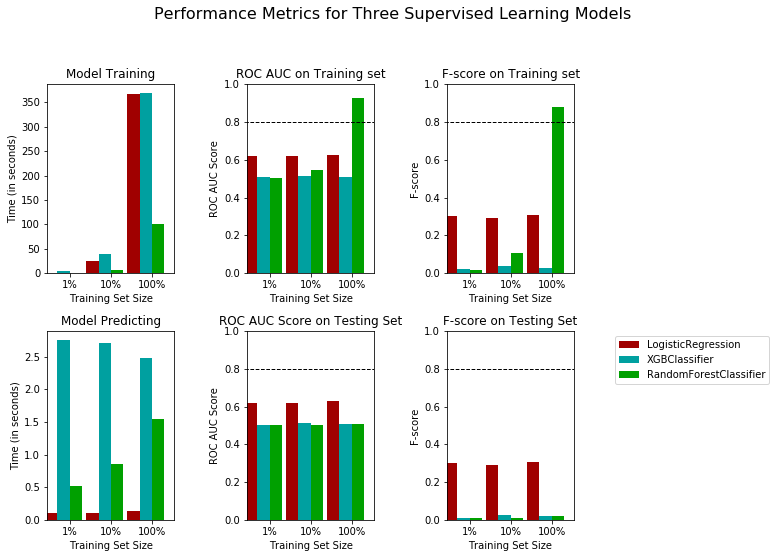

Models performance on full data set:

LogisticRegression 
 Time - Training: 368.0719084262848 	 Testing: 0.12753381729125976 
 ROC AUC - Train: 0.6284147405518116 	 Test: 0.6273054845820759 
 F-Score: Train: 0.30783219597104977 	 Test: 0.30547897917730016
XGBClassifier 
 Time - Training: 368.56242775917053 	 Testing: 2.484958553314209 
 ROC AUC - Train: 0.5117646595517966 	 Test: 0.5075846885210766 
 F-Score: Train: 0.029336337128566335 	 Test: 0.01907530907921972
RandomForestClassifier 
 Time - Training: 100.72100880146027 	 Testing: 1.546179509162903 
 ROC AUC - Train: 0.9270650786610736 	 Test: 0.508039727489781 
 F-Score: Train: 0.8797905930905806 	 Test: 0.02184451501772746


In [46]:
# Calculating results mean
final_results = mean_result(results)

# Run metrics visualization for the three supervised learning models chosen
evaluate(final_results, 0.8, 0.8)

# Checking numeric values for each method used (complete training set)
print("Models performance on full data set:\n")
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    print("{} \n Time - Training: {} \t Testing: {} \n ROC AUC - Train: {} \t Test: {} \n F-Score: Train: {} \t Test: {}" \
          .format(clf_name, \
          final_results[clf_name][2]['train_time'],final_results[clf_name][2]['pred_time'], \
          final_results[clf_name][2]['roc_train'],final_results[clf_name][2]['roc_test'], \
          final_results[clf_name][2]['f_train'], final_results[clf_name][2]['f_test']))

### Unsupervised Learning 

In [69]:
from time import time

def unsupervised_train_predict(classifier, X_train, y_train, X_test, y_test):
    
    results = {}
    
    start = time()
    
    pred_train = classifier.fit_predict(X_train)
    pred_test = classifier.fit_predict(X_test)
    
    end = time()
    
    results['time'] = end - start
    
    # Compute area unders the receive operating characterist curve using roc_auc_acore
    results['roc_train'] = roc_auc_score(y_train, pred_train)
    results['roc_test'] = roc_auc_score(y_test, pred_test)
    
    return results


In [84]:
def average_results(results):
    
    time = 0.0
    roc_train = 0.0
    roc_test = 0.0
    
    
    for clf in results:
        size = len(results[clf])
        for result in results[clf]:
            time += result['time']/size
            roc_train += result['roc_train']/size
            roc_test += result['roc_test']/size

    return [time, roc_train, roc_test]

In [85]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from collections import defaultdict

# clf_A = DBSCAN()
# clf_B = AgglomerativeClustering()
clf_C = KNeighborsClassifier()

results = defaultdict(lambda: [])


clf_name = clf_C.__class__.__name__
for train_index, test_index in skf.split(scale_training_features, training_targets):

    # Separating training and testing data
    X_train, X_test = scale_training_features[train_index], scale_training_features[test_index]
    y_train, y_test = training_targets.iloc[train_index], training_targets.iloc[test_index]

    results[clf_name].append(unsupervised_train_predict(clf, X_train, y_train, X_test, y_test))

final_results = average_results(results)

print("Average measures\nTime: {}\tROC AUC training: {}\t ROC AUC testing: {}".format(final_results[0],final_results[1],final_results[2]))

Average measures
Time: 231.75922617912295	ROC AUC training: 0.49999999999999994	 ROC AUC testing: 0.49999999999999994


### Model Tuning

In [12]:
import lightgbm as lgb

submission_data = pd.read_csv('test.csv')

pred_submission = 0

submission_data.drop('ID_code', axis=1, inplace=True)

results_train = np.empty((0,0))
results_test = np.empty((0,0))

for index, (train_index, test_index) in enumerate(skf.split(filtered_features, filtered_targets)):
    
        print("Fold {}".format(index+1))
        # Separating training and testing data
        X_train, X_test = filtered_features.values[train_index], filtered_features.values[test_index]
        y_train, y_test = filtered_targets[train_index], filtered_targets[test_index]

        # Oversampling minor class
#         X_train, y_train = smt.fit_resample(X_train, y_train)

        # Creating dataset for classifier 
        train_data = lgb.Dataset(X_train, label=y_train[:,0])
        test_data = lgb.Dataset(X_test, label=y_test[:,0])
        
        param = {'random_state':42, 'metric': 'auc', 'bagging_freq': 5, 'bagging_fraction': 0.35,
                 'min_data_in_leaf': 256, 'learning_rate': 0.005, 'objective': 'binary', 'max_leaves': 80,
                 'num_threads': 4, 'is_unbalance': True}
        model = lgb.train(param, train_data, 100000, valid_sets = [train_data, test_data], early_stopping_rounds=2048,verbose_eval=2048)
        
        predictions_train = model.predict(X_train, num_iteration=model.best_iteration)
        predictions_test = model.predict(X_test, num_iteration=model.best_iteration)
        
        train_auc = roc_auc_score(y_train, predictions_train)
        test_auc = roc_auc_score(y_test, predictions_test)
        
        results_train = np.append(results_train, train_auc)
        results_test = np.append(results_test, test_auc)
        
        pred_submission += model.predict(submission_data, num_iteration=model.best_iteration)/n_folds
        
print("Overall train ROC AUC: {}".format(np.mean(results_train)))
print("Overall test ROC AUC: {}".format(np.mean(results_test)))

Fold 1
Training until validation scores don't improve for 2048 rounds.
[2048]	training's auc: 0.969931	valid_1's auc: 0.890834
[4096]	training's auc: 0.989464	valid_1's auc: 0.895319
[6144]	training's auc: 0.997329	valid_1's auc: 0.895559
Early stopping, best iteration is:
[4725]	training's auc: 0.992844	valid_1's auc: 0.895886
Fold 2
Training until validation scores don't improve for 2048 rounds.
[2048]	training's auc: 0.969556	valid_1's auc: 0.893836
[4096]	training's auc: 0.989441	valid_1's auc: 0.898408
[6144]	training's auc: 0.997279	valid_1's auc: 0.898366
[8192]	training's auc: 0.999478	valid_1's auc: 0.898304
Early stopping, best iteration is:
[6244]	training's auc: 0.997475	valid_1's auc: 0.898539
Fold 3
Training until validation scores don't improve for 2048 rounds.
[2048]	training's auc: 0.970255	valid_1's auc: 0.885461
[4096]	training's auc: 0.989541	valid_1's auc: 0.890219
[6144]	training's auc: 0.997321	valid_1's auc: 0.890491
Early stopping, best iteration is:
[4782]	tra

### Kaggle submission

In [13]:
submission['target'] = pred_submission
submission.to_csv('submission.csv', index=False)